In [19]:
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from prediction import preprocess_data

scaler = MinMaxScaler()
start_dat = "2005-01-01"

today = datetime.today().strftime('%Y-%m-%d')

end_dat = today#"2025-05-07"
company = 'MRO'+".L"
n_input = 360*5
n_output = 14
split1 = 0.6
start_seq = 0


In [20]:
import yfinance as yf
import pandas as pd

end_dat = datetime.today()# - pd.Timedelta(days=1)
end_dat = end_dat.strftime('%Y-%m-%d')

df_og = yf.download(company, start= start_dat, 
                    end= end_dat, interval="1d")

df_og = df_og.reset_index()
df_og['Date'] = pd.to_datetime(df_og['Date'])

[*********************100%***********************]  1 of 1 completed


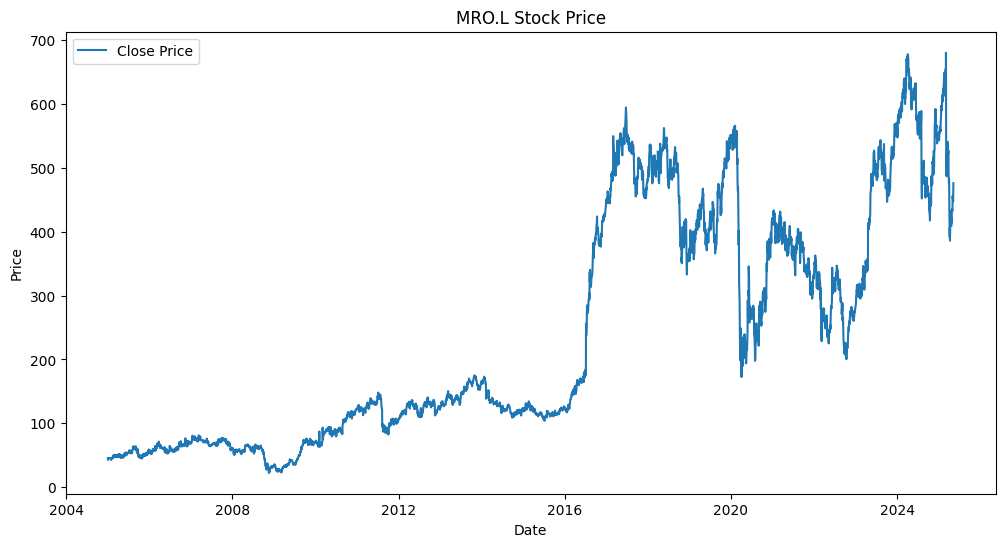

In [21]:
# df_og.isnull().sum()
# scaler.fit(df_og[['Close']])
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(df_og['Date'], df_og['Close'], label='Close Price')
plt.title(f'{company} Stock Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd




def preprocess_data1(company ,start_data, end_date, scaler, n_input=60,n_out = 1, split=0.75,start1=0):
    # Download the data from Yahoo Finance 
    df_og = yf.download(company, start= start_data, 
                    end= end_date, interval="1d")
    
    df_og = df_og.reset_index()

    # Ensure 'Date' is in datetime format
    df_og['Date'] = pd.to_datetime(df_og['Date'])

    # Sort by date to ensure chronological order
    df_og = df_og.sort_values('Date')
    # Drop rows with missing values
    df_og = df_og.dropna()
    # Calculate the split index
    split_idx = int(len(df_og) * split)

    # Split into training and testing sets
    train_df = df_og.iloc[:split_idx]
    test_df = df_og.iloc[split_idx:]


    # Ensure 'Date' is in datetime format
    df_og['Date'] = pd.to_datetime(df_og['Date'])

    # Sort by date to ensure chronological order
    df_og = df_og.sort_values('Date')

    def calulate_average(row):
        return (row['High'] + row['Low']) / 2
    
    df_og['Average'] = df_og['Close']#df.apply(calulate_average, axis=1)

    # Calculate the split index (3/4 for training, 1/4 for testing)
    split_idx = int(len(df_og) * split)

    # Split into training and testing sets
    train_df = df_og.iloc[:split_idx]
    test_df = df_og.iloc[split_idx:]

    
    
    # Scale the 'Close' prices using MinMaxScaler
    scaler.fit(train_df[['Average']])
    train_df['Average'] = scaler.transform(train_df[['Average']])
    test_df['Average'] = scaler.transform(test_df[['Average']])
    out_let = n_out -1
    
    def create_sequences(data, date, seq_len=n_input):
        X, y ,d1= [], [] ,[]
        for i in range(seq_len+out_let, len(data)):
            X.append(data[i-(seq_len+out_let):i-out_let-start1])
            if out_let == 0:
                y.append(data[i])
            else:
                y.append(data[i-out_let:i+1])
            d1.append(date[i])

        return np.array(X), np.array(y), np.array(d1)
    
    # Create sequences for training and testing data
    X_train, y_train, date_train = create_sequences(train_df['Average'].values, train_df['Date'].values, n_input)
    X_test, y_test, date_test = create_sequences(test_df['Average'].values, test_df['Date'].values, n_input)
    
    return X_train, y_train, date_train, X_test, y_test, date_test, scaler , df_og


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['MRO']: YFTzMissingError('possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['MRO']: YFTzMissingError('possibly delisted; no timezone found')


ValueError: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required by MinMaxScaler.

In [5]:
# print(end_dat)
y_test.shape , X_test.shape, date_test.shape, X_train.shape, y_train.shape, date_train.shape

((236, 14), (236, 1800), (236,), (1259, 1800), (1259, 14), (1259,))

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))

plt.plot(dta_og['Date'], dta_og['Close'], label='Actual Price', color='blue')

plt.show()
# dta_og

In [8]:
from tensorflow.keras.metrics import MeanSquaredError, RootMeanSquaredError
from tensorflow.keras.layers import Input, GRU, Dropout, Dense
from tensorflow.keras.models import Model
from prediction import create_model,full_dataset2 , calulate_total


def create_model2(n_input1 , n_features1,n_output1, optimizer1='adam', loss1='mean_squared_error',
    metrics1=[MeanSquaredError(), RootMeanSquaredError()]):
    
    # Build the model
    # Input layer
    input_layer = Input(shape=(n_input1, n_features1), name="Input_Layer")  
    
    # GRU layers
    X = GRU(units=64, return_sequences=True, name="GRU_Layer1")(input_layer)  # Return sequences for next GRU
    X = Dropout(0.2, name="Dropout1")(X)  # Prevent overfitting

    X = GRU(units=32, return_sequences=False, name="GRU_Layer2")(X)  # Final GRU output
    X = Dropout(0.2, name="Dropout2")(X)

    # Dense layers
    X = Dense(16, activation='relu', name="Dense_Layer")(X)

    # Output layer
    output_layer = Dense(n_output1, name="Output_Layer")(X)


    # Create the model
    model1 = Model(inputs=input_layer, outputs=output_layer) 

    # Compile the model
    model1.compile(optimizer=optimizer1, loss=loss1 ,    metrics=metrics1 ) 
    
    return model1



In [25]:
model3 = create_model2(n_input, 1, n_output, optimizer1='adam',
                       loss1='mean_squared_error', metrics1=[MeanSquaredError()])
# X_train.shape, y_train.shape, date_train.shape
# model3 =  create_model(n_input -start_seq, 1,n_output, optimizer1='adam', 
                    #    loss1='mean_squared_error',metrics1=[MeanSquaredError()])
# model3.__dict__
model3.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_Layer (InputLayer)    [(None, 1800, 1)]         0         
                                                                 
 GRU_Layer1 (GRU)            (None, 1800, 64)          12864     
                                                                 
 Dropout1 (Dropout)          (None, 1800, 64)          0         
                                                                 
 GRU_Layer2 (GRU)            (None, 32)                9408      
                                                                 
 Dropout2 (Dropout)          (None, 32)                0         
                                                                 
 Dense_Layer (Dense)         (None, 16)                528       
                                                                 
 Output_Layer (Dense)        (None, 14)                238 

In [ ]:
import os
from tensorflow.keras.models import load_model
name_1 = 'model_' + company + '_' + str(n_input) + '_' + str(n_output) + '.keras'#'.weights.h5'
if os.path.exists(name_1):
    loaded_model = load_model(name_1)
    #model3.load_weights(name_1)

In [ ]:
# 
# dot_img_file = os.path.join(os.getcwd(), 'model3.png')  # Saves to current directory
# from tensorflow.keras.utils import plot_model
# plot_model(model3, to_file='model3.png', show_shapes=True,
#                          expand_nested=True, dpi=50)

In [26]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define the early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=5,  # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

# Define the model checkpoint callback
checkpoint_filepath = 'model_checkpoint.h5'
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True
)

# Fit the model with the callbacks
history = model3.fit(
    X_train, y_train,
    epochs=20, 
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=2,
    callbacks=[early_stopping, checkpoint_callback]
)

Epoch 1/20
40/40 - 28s - loss: 0.0378 - mean_squared_error: 0.0378 - val_loss: 0.0102 - val_mean_squared_error: 0.0102 - 28s/epoch - 692ms/step
Epoch 2/20
40/40 - 33s - loss: 0.0122 - mean_squared_error: 0.0122 - val_loss: 0.0017 - val_mean_squared_error: 0.0017 - 33s/epoch - 830ms/step
Epoch 3/20
40/40 - 32s - loss: 0.0045 - mean_squared_error: 0.0045 - val_loss: 7.7977e-04 - val_mean_squared_error: 7.7977e-04 - 32s/epoch - 794ms/step
Epoch 4/20
40/40 - 33s - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 9.3826e-04 - val_mean_squared_error: 9.3826e-04 - 33s/epoch - 831ms/step
Epoch 5/20
40/40 - 33s - loss: 0.0027 - mean_squared_error: 0.0027 - val_loss: 0.0011 - val_mean_squared_error: 0.0011 - 33s/epoch - 817ms/step
Epoch 6/20
40/40 - 32s - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 7.0268e-04 - val_mean_squared_error: 7.0268e-04 - 32s/epoch - 810ms/step
Epoch 7/20
40/40 - 33s - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 9.8803e-04 - val_mean_squared_err

In [27]:
# name_1 = 'model_' + company + '_' + str(n_input) + '_' + str(n_output) + '.keras'#'.weights.h5'
# model3.save(name_1)
model4 = create_model2(n_input, 1, n_output, optimizer1='adam',
                       loss1='mean_squared_error', metrics1=[MeanSquaredError()])

checkpoint_filepath = 'model_checkpoint.h5'
model4.load_weights(checkpoint_filepath)

loss, mae = model4.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {loss:.4f}, Test MAE: {mae:.4f}")
# model3.save_weights(name_1)

Test Loss: 0.0007, Test MAE: 0.0007


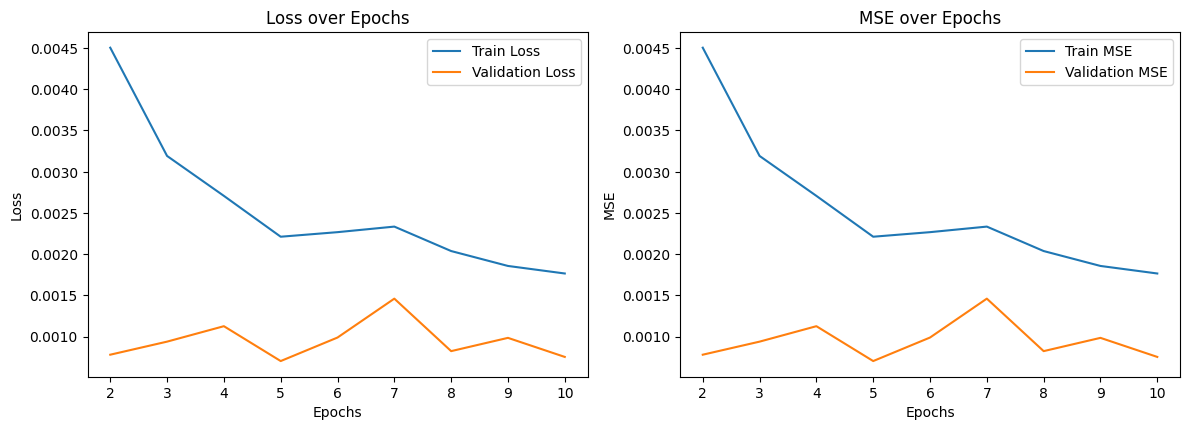

In [30]:
# # history.history.keys()
from prediction import plot_loss
plot_loss(history,start_epoch=2)

In [31]:
from prediction import explainablity_lime

exp1 = explainablity_lime(X_train, X_test, model4, 0)

157/157 [==============================] - 18s 113ms/step
Intercept 0.2204974857211357
Prediction_local [0.13162846]
Right: 0.1337294


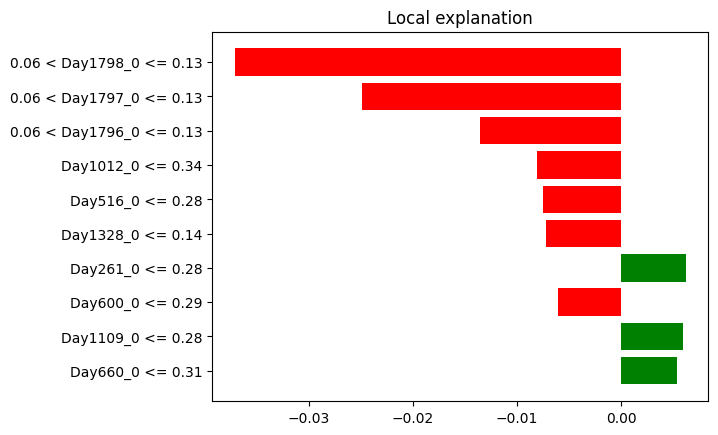

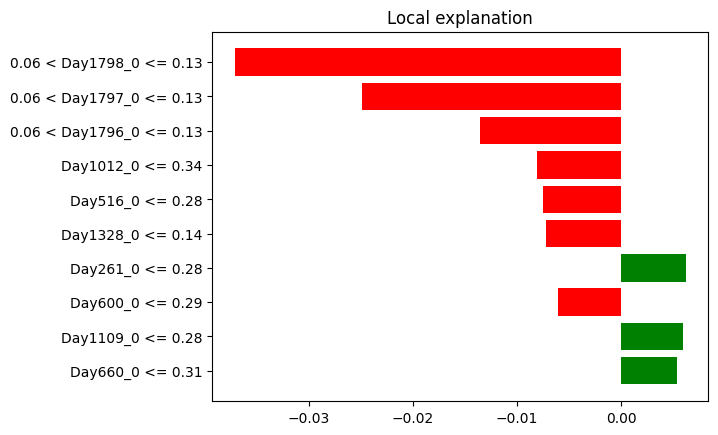

In [24]:
exp1.as_pyplot_figure()

In [32]:
# Extract LIME values (feature index and corresponding weight)
lime_values = exp1.local_exp[1]  # 1 for regression/classification output
feature_names = [f"Day{i}" for i in range(X_train.shape[1])]
# Convert to dictionary: {feature_name: lime_weight}
lime_dict = {feature_names[feat_idx]: weight for feat_idx, weight in lime_values}

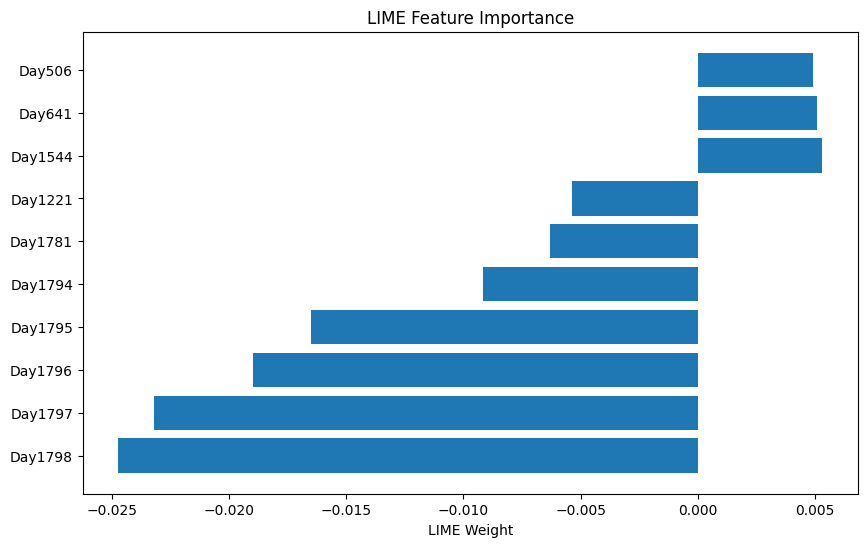

In [33]:
plt.figure(figsize=(10, 6))
plt.barh(list(lime_dict.keys()), list(lime_dict.values()))
plt.xlabel('LIME Weight')
plt.title('LIME Feature Importance')
plt.show()


In [ ]:
import numpy as np
import pandas as pd

# def full_dataset1(model3 , X_test, y_test,  date_test, scaler1):
scaler1 = scaler


full_actual = np.concatenate([y_test]) #y_train, 
# full_actual = scaler1.inverse_transform(full_actual.reshape(-1, 1)).flatten()

predicted_test = model3.predict(X_test)
predicted_prices = scaler1.inverse_transform(predicted_test)

# full_predicted = predicted_prices.flatten()[:]

date_range = date_test.tolist()
date_range = pd.to_datetime(date_range)

date_range.shape, full_actual.shape, predicted_prices.shape,X_test.shape

8/8 [==============================] - 1s 110ms/step


((236,), (236, 14), (236, 14), (236, 1800))

In [42]:
start_dates = date_range - pd.Timedelta(days=n_output)

In [ ]:
# start_dates[0] , date_range[0]

(Timestamp('2024-05-17 00:00:00'), Timestamp('2024-05-31 00:00:00'))

In [5]:
# date_range[0]
num_in = 6
max = (236-n_output)/num_in 
max = int(max)
for i in range(0,2):
    # print(f'index1: {i}')

    
    fig, ax = plt.subplots(1, 2 , figsize =(20,5))#num_in, figsize=(5*num_in, 4))  # 1x2 grid, adjustable size    
    # plt.figure(figsize=(8,2))
    # plt.subplot(1, 2, 1)
    for j in range(0,1):#num_in):
        index1 = i*num_in+j#8
        dates= np.empty((n_output), dtype='datetime64[ns]')

        for i1 in range(n_output):
            dates[i1] = date_range[i1+index1] - pd.Timedelta(days=n_output-i1)

        f_price = scaler1.inverse_transform(full_actual[index1,:].reshape(-1, 1)).flatten()
        p_price = predicted_prices[index1,:]
        
        ax[j].plot(dates, f_price, label='Actual Price', color='blue')
        ax[j].plot(dates, p_price, label='Predicted Price', color='red')  # Fixed label
        ax[j].set_title(f"Price Prediction for {company} ({n_output} Days Ahead)")
        ax[j].set_xlabel('Date')
        ax[j].set_ylabel('Price')
        ax[j].tick_params(axis='x', rotation=90)  # Rotate x-axis labels
        ax[j].legend()  # Add legend to show Actual vs Predicted
        ax[j].grid(True)
    ###########
    # index1 = i*2+1#8
    # dates= np.empty((n_output), dtype='datetime64[ns]')
    # for i in range(n_output):
    #     dates[i] = date_range[i+index1] - pd.Timedelta(days=n_output-i)
    # f_price = scaler1.inverse_transform(full_actual[index1,:].reshape(-1, 1)).flatten()
    # p_price = predicted_prices[index1,:]

    # plt.plot(dates, f_price, label='Actual Price', color='blue')
    # plt.plot(dates, p_price, label='Actual Price', color='red')
    # plt.title(f"Price prediction for {company} for {n_output} days ahead")
    # plt.xlabel('Date')
    # plt.xticks(rotation=90)
    # plt.ylabel('Price')
    # plt.grid(True)

    plt.tight_layout()
    plt.show()

NameError: name 'plt' is not defined

In [ ]:
# calulate_total(df, diplaty1=True, statsistics1=False)
# calulate_total(df2, diplaty1=True, statsistics1=False)

In [ ]:
from prediction import display_trends
import pandas as pd

display_trends(dta_og , df)
display_trends(dta_og , df2)

KeyError: 'Date'